In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# from model import train_xgb

In [3]:
# c = [ 'Entries added in pipe', 'Amount added in pipe',
#        'Opportunity Weighted Amount', 'Unique accounts added in pipe',
#        'Projects won', 'Amount won', 'Unique accounts won', 'Manager_Util',
#        'Senior Associate_Util', 'Senior Manager_Util', 'Associate_Util',
#        'Director_Util', 'Director diff from Target', 'SM diff from Target',
#        'Associate diff from Target', 'Manager diff from Target',
#        'SA diff from Target', 'Fracn of team as As', 'Fracn of team as SAs',
#        'Fracn of teams as SMs', 'Fracn of teams as Ms', 'Fracn of teams as Ds',
#        'Frac Client Code Manager-Director', 'Frac PD Code Manager-Director',
#        'Frac 4 Code Manager-Director', 'Frac PD Code M-',
#        'Frac Client Code M-', 'Frac 4 Code M-', 'business_days',
#        'log of team size']

In [4]:
# outputs_1 = train_xgb(1, ['6.0_2022.0'], c, 'datafull/features_and_models/')

In [5]:
# outputs_2 = train_xgb(2, ['6.0_2022.0', '5.0_2022.0'], c, 'datafull/features_and_models_2/')


In [6]:
# from model import combine_outputs

In [7]:
# in_scope = ["ESV - PLS",
# "ESV - BCM",
# "DDV - IT",
# "FS - Banking and Capital Markets",
# "DDV - Operations",
# "Finance - Enterprise Performance Management"]

In [8]:
# to_save = combine_outputs(outputs_1, outputs_2, in_scope)

In [9]:
# to_save

In [10]:
from model import load_df, preprocess_df, impute_missing
all_data_df = load_df(model_t_plus=1)
all_data_df = impute_missing(all_data_df)
all_data_df, to_pred, gc_time = preprocess_df(all_data_df, months_to_predict=['6.0_2022.0'], model_t_plus=1) 

## Feature Engineering

In [11]:
# from sklearn.feature_selection import SequentialFeatureSelector
# from joblib import dump, load
# from xgboost import XGBRegressor
# import os
# from model import train_xgb_with_custom_features
# from sklearn.preprocessing import OneHotEncoder
# import pandas as pd

### 1) Excluding Growth Cell

In [12]:
# c = list(all_data_df.columns)
# c.remove('Revenue Sum + 1')
# c.remove('Growth Cell')

In [13]:
# train_xgb(1, ['6.0_2022.0'], c, 'datafull/no_growthcell/')

### 2) Using hash of Growth Cell

In [14]:
# all_data_df['Growth Cell Hash']=all_data_df['Growth Cell'].apply(lambda x: hash(x))

In [15]:
# c = list(all_data_df.columns)
# c.remove('Revenue Sum + 1')
# c.remove('Growth Cell')

In [16]:
# train_xgb_with_custom_features(c, all_data_df, to_pred, 'datafull/hash_growthcell/')

In [17]:
# all_data_df.drop(['Growth Cell Hash'], axis=1, inplace=True)

### 3) Using One-Hot Encoding of Growth Cell

In [18]:
# enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
# enc.fit(all_data_df[['Growth Cell']])

In [19]:
# onehot = pd.DataFrame(enc.transform(all_data_df[['Growth Cell']]), columns=enc.get_feature_names(),index=all_data_df.index)
# data = pd.concat([all_data_df.drop("Growth Cell", axis=1), onehot],axis=1)

In [20]:
# c=list(data.columns)
# c.remove('Revenue Sum + 1')

In [21]:
# train_xgb_with_custom_features(c, data, to_pred, 'datafull/onehot_growthcell/')

## Clustering numerical features

In [22]:
numerical_cols=all_data_df.select_dtypes(include=['int64','float64']).columns.to_list()

In [23]:
clustering_features=numerical_cols.copy()
clustering_features.remove('Revenue Sum + 1')
clustering_features.remove('Revenue Sum')

In [24]:
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AffinityPropagation
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import os

### 1) Using K-Means Clustering

In [25]:
wcss = [] 
for number_of_clusters in range(2, 20): 
    kmeans = KMeans(n_clusters = number_of_clusters, random_state = 0, algorithm='elkan')
    kmeans.fit(all_data_df[clustering_features])
    wcss.append(kmeans.inertia_)

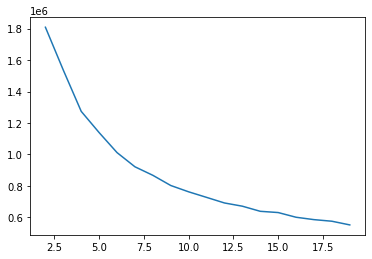

In [26]:
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
plt.plot(ks, wcss)

In [27]:
optimal_clusters=8

In [28]:
kmeans = KMeans(n_clusters = optimal_clusters, random_state = 0, algorithm='elkan')
kmeans.fit(all_data_df[clustering_features])

KMeans(algorithm='elkan', random_state=0)

In [29]:
kmeans.labels_

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5,
       0, 0, 0, 5, 5, 0, 5, 5, 1, 1, 3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 5, 5, 1, 5, 5, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 5, 0, 0, 0, 0, 1, 1, 3, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 3, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       6, 1, 3, 3, 3, 0, 0, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 7, 7,
       3, 7, 3, 3, 3, 3, 3, 3, 1, 7, 3, 7, 7, 7, 3, 5, 5, 5, 5, 5, 5, 5,
       5, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1,
       3, 3, 0, 0, 3, 3, 3, 3, 3, 1, 1, 7, 7, 0, 0, 0, 0, 7, 0, 3, 1, 1,
       3, 3, 3, 3, 3, 3, 3, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 5, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 3, 3, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 3, 3, 0, 3, 3, 3, 1,
       1, 1, 1, 1, 1, 1, 3, 3, 0, 6, 6, 6, 1, 3, 3,

In [30]:
np.unique(kmeans.labels_,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([144, 111,  10,  84,   1,  74,  28,  19], dtype=int64))

In [31]:
silhouette_score(all_data_df[clustering_features], kmeans.labels_)

0.1545156409966284

### 2) Using DBSCAN Clustering

In [32]:
for metric in ['euclidean', 'manhattan', 'chebyshev', 'canberra', 'braycurtis', 'correlation', 'hamming']:
    model = DBSCAN(metric=metric,min_samples=5)
    model.fit(all_data_df[clustering_features])
    try:
        print(metric,silhouette_score(all_data_df[clustering_features], model.labels_))
    except:
        continue
    print()

correlation 0.8424660873228172

hamming 0.12300763180768802



In [33]:
dbscan=DBSCAN(metric='correlation',min_samples=5)
dbscan.fit(all_data_df[clustering_features])

DBSCAN(metric='correlation')

In [34]:
dbscan.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [35]:
np.unique(dbscan.labels_,return_counts=True)

(array([-1,  0], dtype=int64), array([  1, 470], dtype=int64))

### 3) Using mean-shift Clustering

In [36]:
mean_shift=MeanShift(n_jobs=-1)
mean_shift.fit(all_data_df[clustering_features])

MeanShift(n_jobs=-1)

In [37]:
silhouette_score(all_data_df[clustering_features], mean_shift.labels_)

0.2825730251445666

In [38]:
mean_shift.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 2, 8, 2, 2, 2, 2, 2, 2, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       5, 5, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 3, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [39]:
np.unique(mean_shift.labels_,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([438,   9,   9,   4,   3,   2,   1,   1,   2,   2], dtype=int64))

### 4) Using Affinity Propagation Clustering

In [40]:
affinity_propagation=AffinityPropagation(random_state=0,damping=0.5)
affinity_propagation.fit(all_data_df[clustering_features])

AffinityPropagation(random_state=0)

In [41]:
silhouette_score(all_data_df[clustering_features], affinity_propagation.labels_)

0.16745516153196427

In [42]:
affinity_propagation.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  3, 25, 24, 24,  3,  3,
        3,  3,  3,  0,  0,  4,  4,  4,  4,  5,  5,  5,  5,  7, 23, 31, 31,
        4, 25, 27, 27, 24, 24,  7,  7,  4,  4,  4, 38,  5,  5,  5,  5,  7,
        7,  4, 26, 26, 25, 31, 40,  4,  4,  4,  4, 24, 41, 24, 24, 24, 26,
       27, 27,  6,  6,  6,  6,  7, 25, 25, 26, 26, 26, 23, 23, 31,  4, 39,
       39,  4, 26,  4,  4,  4, 23, 23, 23,  4,  4,  4, 31, 31, 31,  7,  7,
        7,  7,  7,  7,  7, 40, 40,  7, 36, 23, 31, 13, 13, 31, 25, 37, 37,
       37,  8,  9, 10, 10,  9, 10, 11, 11,  9, 34, 12, 12, 14, 14, 17, 31,
       17, 13, 13, 13, 41, 12, 12, 14, 14, 14, 31,  7, 39, 38, 15, 15, 15,
       15, 15,  7, 40, 16, 17, 17, 22, 22, 22, 22, 22, 17, 17, 17, 17, 22,
       22, 22, 13, 33, 13, 26, 18, 18, 19, 19, 17, 12, 17, 12, 13, 16, 16,
       16, 21, 20, 20, 33, 20, 21, 21, 17, 23, 23, 31, 31, 22, 22, 22, 17,
       22,  4, 23, 23, 23, 23, 25, 24, 24, 24, 24,  4, 23, 23, 23, 23, 23,
       27, 27, 27, 27,  7

In [43]:
np.unique(affinity_propagation.labels_,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
       dtype=int64),
 array([13,  1,  1,  9, 34, 12,  5, 22,  1,  3,  3,  2,  6,  8,  5,  5,  6,
        12,  2,  2,  3,  3, 12, 31, 16, 23, 27, 24,  3,  9,  5, 35,  2,  5,
        12, 12,  3,  8, 14, 14, 13, 10, 10,  5,  1,  6,  3,  1,  9],
       dtype=int64))

### Only K-Means Clustering seems to be working well

In [44]:
cluster_ids=kmeans.predict(all_data_df[clustering_features])
onehot_cluster_ids=pd.DataFrame(pd.get_dummies(cluster_ids,prefix='cluster_id').to_numpy(),index=all_data_df.index)

In [45]:
data = pd.concat([all_data_df.drop("Growth Cell", axis=1), onehot_cluster_ids],axis=1)

In [46]:
c=list(data.columns)
c.remove('Revenue Sum + 1')

In [47]:
from model import train_xgb_with_custom_features

In [ ]:
if os.path.exists('datafull/onehot_growthcell_cluster/')==False:
    os.mkdir('datafull/onehot_growthcell_cluster/')
train_xgb_with_custom_features(c, data, to_pred, 'datafull/onehot_growthcell_cluster/')

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
STOP HERE

# CausalML

In [ ]:
from causalml.inference.meta import XGBTRegressor
from xgboost import XGBRegressor

In [ ]:
y_causal = all_data_df["Revenue Sum + 1"]
collected_data2 = []
for i in range(len(keep_columns_xgb)):
    treatment_ = all_data_df[keep_columns_xgb[i]]
    X_causal = all_data_df[keep_columns_xgb].drop([keep_columns_xgb[i]], axis = 1)
    treatment = np.array([1 if x>treatment_.median() else 0 for x in treatment_])
    xg = XGBTRegressor(random_state=42,n_jobs=-1)
    te, lb, ub = xg.estimate_ate(X_causal, treatment, y_causal)
    print(keep_columns_xgb[i])
    print(treatment_.median())
    print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))
    collected_data2 = collected_data2 + [[keep_columns_xgb[i], treatment_.median(), te[0]]]

In [ ]:
import pandas as pd

In [ ]:
f = pd.DataFrame(collected_data2)

In [ ]:
f.columns = ['Feature', 'Median', 'ATE']

In [ ]:
f['Size of Effect'] = f['ATE'].apply(lambda x: (np.exp(np.abs(x)) - 1)*100)

In [ ]:
f.sort_values('ATE', ascending = False)

In [ ]:
pd.DataFrame(all_data_df.columns.values)